In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import math


In [2]:
def get_edge_orientation_histogram(img_gray):
    height, width = img_gray.shape
    ori_img_gray = np.zeros((height, width), np.float32) #gradient orientation of img_gr
    D_x = np.float32([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8
    der_x = cv.filter2D(img_gray, cv.CV_32F, D_x) #the 2nd parameter of filter2D is set to CV_32F to store negative values
    plt.imshow(der_x, 'gray')
    plt.show()
    D_y = np.float32([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) / 8
    der_y = cv.filter2D(img_gray, cv.CV_32F, D_y) #the 2nd parameter of filter2D is set to CV_32F to store negative values
    plt.imshow(der_y, 'gray')
    plt.show()
    height, width = img_gray.shape
    for i in range(0, height):
        for j in range(0, width):
            if (der_x[i,j] == 0) and (der_y[i,j] == 0):
                ori_img_gray[i,j] = math.inf
            else:
                ori_img_gray[i,j] = math.atan2(der_y[i,j], der_x[i,j])
                ori_img_gray[i,j] = (ori_img_gray[i,j] * 180)/math.pi
                ori_img_gray[i,j] = ori_img_gray[i,j] + 90
                if (ori_img_gray[i,j] < 0) and (ori_img_gray[i,j] >= -90):
                    ori_img_gray[i,j] = ori_img_gray[i,j] + 360
    plt.imshow(ori_img_gray,'gray')
    plt.show()
    return ori_img_gray

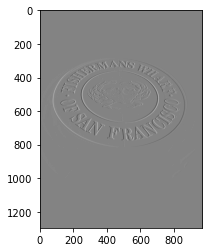

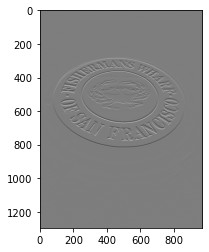

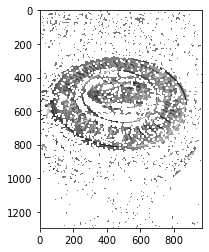

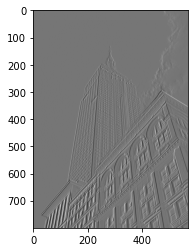

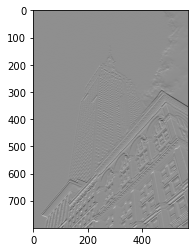

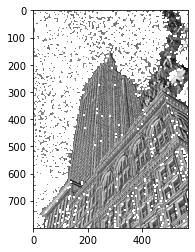

In [3]:
img_fisherman = cv.imread('fisherman.jpg') #load image
img_gray_fisherman = cv.cvtColor(img_fisherman, cv.COLOR_BGR2GRAY)
ori_img_gray_fisherman = get_edge_orientation_histogram(img_gray_fisherman)

img_empire = cv.imread('empire.jpg') #load image
img_gray_empire = cv.cvtColor(img_empire, cv.COLOR_BGR2GRAY)
ori_img_gray_empire = get_edge_orientation_histogram(img_gray_empire)

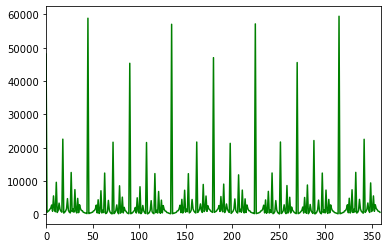

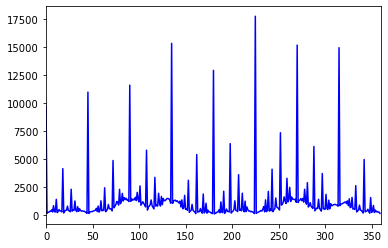

In [4]:
ori_img_gray_fisherman = np.round(ori_img_gray_fisherman, 0)
hist_fisherman = cv.calcHist([ori_img_gray_fisherman],[0],None,[360],[0,360])
plt.plot(hist_fisherman, color = 'g')
plt.xlim([0,360])
plt.show()

ori_img_gray_empire = np.round(ori_img_gray_empire, 0)
hist_empire = cv.calcHist([ori_img_gray_empire],[0],None,[360],[0,360])
plt.plot(hist_empire, color = 'b')
plt.xlim([0,360])
plt.show()

In [5]:
def NormaliseHist(hist):
    s = 0
    hist_norm = hist.copy()
    for i in range(0, len(hist_norm)):
        s = s + hist_norm[i]
    for i in range(0, len(hist_norm)):
        hist_norm[i] = hist_norm[i] / s
    return hist_norm   

###Assuming both hist to be of same dims, if not then do padding
def X2Dist(h1,h2):
    x2_dist = 0
    for i in range (0, len(h1)):
        #to prevent divide by zero error
        if h1[i] == 0:
            h1[i] = 0.000001
        if h2[i] == 0:
            h2[i] = 0.000001
        x2_dist += ((h1[i] - h2[i]) * (h1[i] - h2[i])) / (h1[i] + h2[i])
    return x2_dist

###Assuming both hist to be of same dims, if not then do padding
def KLDivergence(h1,h2):
    kld = 0
    for i in range(0, len(h1)):
        #to prevent divide by zero error
        if h1[i] == 0:
            h1[i] = 0.000001
        if h2[i] == 0:
            h2[i] = 0.000001
        #print (h1[i], h2[i])

        kld += h1[i] * math.log(h1[i]/h2[i])
    return kld   



In [6]:
chi = X2Dist(NormaliseHist(hist_fisherman), NormaliseHist(hist_empire))
print(chi)
kld = KLDivergence(NormaliseHist(hist_fisherman), NormaliseHist(hist_empire)) + \
KLDivergence(NormaliseHist(hist_empire), NormaliseHist(hist_fisherman))
print(kld)

[0.2154838]
[0.5181271]


### Task 2: Skew Estimation

In [7]:
###Skew estimation
doc = cv.imread('doc.jpg', 0)
threshold = 200
ret, doc_bin = cv.threshold(doc, threshold, 255, cv.THRESH_BINARY)
cv.imwrite('doc_bin.png', doc_bin)

True

<ipython-input-8-3cb5e7f6fc46>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  closing_se = np.ones((1, 15), np.int) #structuring element for clos


True

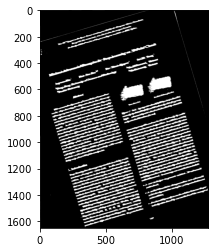

In [8]:
closing_se = np.ones((1, 15), np.int) #structuring element for clos
doc_bin = 255 - doc_bin #convert black/white to white/bla
closing = cv.morphologyEx(doc_bin, cv.MORPH_CLOSE, closing_se)
plt.imshow(closing, 'gray')
cv.imwrite('doc_closing.png', closing)

<ipython-input-9-3ac334320f80>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  opening_se = np.ones((8, 8), np.int) #structuring element for openi


True

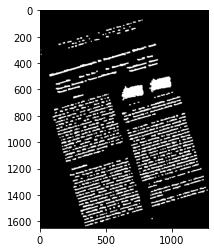

In [9]:
opening_se = np.ones((8, 8), np.int) #structuring element for openi
opening = cv.morphologyEx(closing, cv.MORPH_OPEN, opening_se)
plt.imshow(opening, 'gray')
cv.imwrite('doc_opening.png', opening)

In [10]:
# connected component labelling
num_labels, labels_im = cv.connectedComponents(opening)


In [11]:
print (num_labels)

730


In [12]:
def ExtractConnectedComponents(num_labels, labels_im):
    connected_components = [[] for i in range(0, num_labels)]
    height, width = labels_im.shape
    for i in range(0, height):
        for j in range(0, width):
            if labels_im[i, j] >= 0:
                connected_components[labels_im[i, j]].append((j, i))
    return connected_components

In [13]:
connected_components = ExtractConnectedComponents(num_labels, labels_im)


In [14]:
import math
def FindOrientation(cc):
    mx = 0
    my = 0
    mxx = 0
    myy = 0
    mxy = 0
    for i in range(0, len(cc)):
        mx += cc[i][0] # cc[i][0] is used to store the x coordinate of pixel cc[i]
        my += cc[i][1] # cc[i][1] is used to store the y coordinate of pixel cc[i]
    mx /= len(cc)
    my /= len(cc)
    for i in range(0, len(cc)):
        dx = cc[i][0] - mx
        dy = cc[i][1] - my
        mxx += (dx * dx)
        myy += (dy * dy)
        mxy += (dx * dy)
    mxx /= len(cc)
    myy /= len(cc)
    mxy /= len(cc)
    theta = - math.atan2(2 * mxy, mxx - myy) / 2
    return theta

In [15]:
orientations = np.zeros(num_labels, np.float32)
for i in range(0, num_labels):
    orientations[i] = FindOrientation(connected_components[i])

In [16]:
import statistics
orientation = statistics.median(orientations)
print("Angle: ", orientation)

Angle:  0.23484191298484802


True

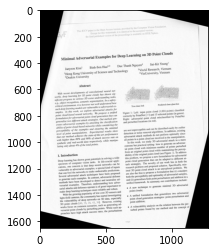

In [17]:
# rotate image
height, width = doc.shape
c_x = (width - 1) / 2.0 # column index varies in [0, width-1]
c_y = (height - 1) / 2.0 # row index varies in [0, height-1]
c = (c_x, c_y) # A point is defined by x and y coordinate
M = cv.getRotationMatrix2D(c, -orientation * 180 / math.pi, 1)
doc_deskewed = cv.warpAffine(doc, M, (width, height))
plt.imshow(doc_deskewed, 'gray')
cv.imwrite('doc_deskewed.png', doc_deskewed)

<ipython-input-18-860f8e280811>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  closing_se = np.ones((1, 15), np.int) #structuring element for clos


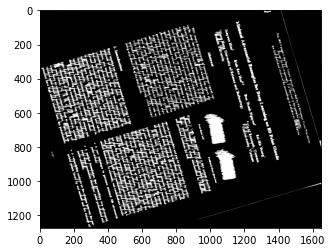

<ipython-input-18-860f8e280811>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  opening_se = np.ones((8, 8), np.int) #structuring element for openi


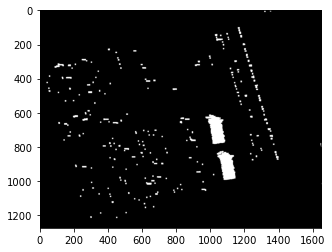

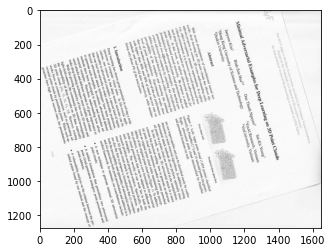

True

In [18]:
###Skew estimation using same stryctruing element
doc = cv.imread('doc_1.jpg', 0)
threshold = 200
ret, doc_bin = cv.threshold(doc, threshold, 255, cv.THRESH_BINARY)
cv.imwrite('doc_1_bin.png', doc_bin)
closing_se = np.ones((1, 15), np.int) #structuring element for clos
doc_bin = 255 - doc_bin #convert black/white to white/bla

closing = cv.morphologyEx(doc_bin, cv.MORPH_CLOSE, closing_se)
plt.imshow(closing, 'gray')
plt.show()
cv.imwrite('doc_1_same_se_closing.png', closing)

opening_se = np.ones((8, 8), np.int) #structuring element for openi
opening = cv.morphologyEx(closing, cv.MORPH_OPEN, opening_se)
plt.imshow(opening, 'gray')
plt.show()
cv.imwrite('doc_1_same_se_opening.png', closing)

# connected component labelling
num_labels, labels_im = cv.connectedComponents(opening)
connected_components = ExtractConnectedComponents(num_labels, labels_im)
orientations = np.zeros(num_labels, np.float32)
for i in range(0, num_labels):
    orientations[i] = FindOrientation(connected_components[i])
    
orientation = statistics.median(orientations)
# rotate image
height, width = doc.shape
c_x = (width - 1) / 2.0 # column index varies in [0, width-1]
c_y = (height - 1) / 2.0 # row index varies in [0, height-1]
c = (c_x, c_y) # A point is defined by x and y coordinate
M = cv.getRotationMatrix2D(c, -orientation * 180 / math.pi, 1)
doc_deskewed = cv.warpAffine(doc, M, (width, height))
plt.imshow(doc_deskewed, 'gray')
plt.show()
cv.imwrite('doc_deskewed_same_se.png', doc_deskewed)

<ipython-input-19-44f4e057c1c7>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  closing_se = np.ones((15, 1), np.int) #structuring element for clos


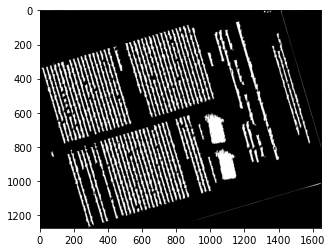

<ipython-input-19-44f4e057c1c7>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  opening_se = np.ones((8, 8), np.int) #structuring element for openi


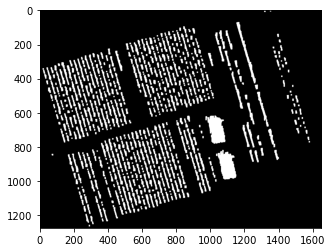

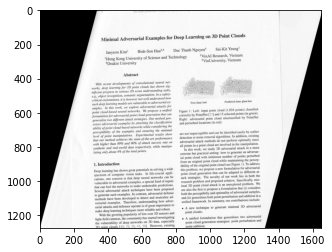

In [19]:
###Skew estimation using different structring element for closing
doc = cv.imread('doc_1.jpg', 0)
threshold = 200
ret, doc_bin = cv.threshold(doc, threshold, 255, cv.THRESH_BINARY)
cv.imwrite('doc_1_bin.png', doc_bin)
closing_se = np.ones((15, 1), np.int) #structuring element for clos
doc_bin = 255 - doc_bin #convert black/white to white/bla

closing = cv.morphologyEx(doc_bin, cv.MORPH_CLOSE, closing_se)
plt.imshow(closing, 'gray')
plt.show()
cv.imwrite('doc_1_closing.png', closing)

opening_se = np.ones((8, 8), np.int) #structuring element for openi
opening = cv.morphologyEx(closing, cv.MORPH_OPEN, opening_se)
plt.imshow(opening, 'gray')
plt.show()
cv.imwrite('doc_1_opening.png', closing)

# connected component labelling
num_labels, labels_im = cv.connectedComponents(opening)
connected_components = ExtractConnectedComponents(num_labels, labels_im)
orientations = np.zeros(num_labels, np.float32)
for i in range(0, num_labels):
    orientations[i] = FindOrientation(connected_components[i])
    
orientation = statistics.median(orientations)
# rotate image
height, width = doc.shape
c_x = (width - 1) / 2.0 # column index varies in [0, width-1]
c_y = (height - 1) / 2.0 # row index varies in [0, height-1]
c = (c_x, c_y) # A point is defined by x and y coordinate
M = cv.getRotationMatrix2D(c, -orientation * 180 / math.pi, 1)
doc_deskewed = cv.warpAffine(doc, M, (width, height))
plt.imshow(doc_deskewed, 'gray')
cv.imwrite('doc_deskewed_diff_se.png', doc_deskewed)
plt.show()